# Rmagic Functions Extension

## Line magics

IPython has an `rmagic` extension that contains a some magic functions for working with R via rpy2. This extension can be loaded using the `%load_ext` magic as follows:

In [85]:
%load_ext rpy2.ipython
% precision 3

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


'%.3f'

## A simple example: scatter-plot
A typical use case one imagines is having some numpy arrays, wanting to compute some statistics of interest on these
 arrays and return the result back to python. Let's suppose we just want to fit a simple linear model to a scatterplot.

In [86]:
# First we generate and plot the data in Python

import numpy as np
import pylab
X = np.array([0,1,2,3,4])
Y = np.array([3,5,4,6,7])
pylab.scatter(X, Y)

## Pushing Python variables into R, and executing R-commands in IPython

We can accomplish this by first pushing variables to R, fitting a model and returning the results. The line magic %Rpush copies its arguments to variables of the same name in rpy2. The %R line magic evaluates the string in rpy2 and returns the results. In this case, the coefficients of a linear model.

In [87]:
%Rpush X Y
%R lm(Y~X)$coef

array([ 3.2,  0.9])

In [88]:
# Note: %Rpush is equivalent to calling %R with just -i and no trailing code.
A = np.arange(20)
%R -i A
%R mean(A)

array([ 9.5])

In [89]:
# We can check that the computation in R is correct fairly easily:

Xr = X - X.mean()
Yr = Y - Y.mean()
slope = (Xr*Yr).sum() / (Xr**2).sum()
intercept = Y.mean() - X.mean() * slope
(intercept, slope)

(3.200, 0.900)

In [90]:
# It is also possible to return more than one value with %R.
%R resid(lm(Y~X)); coef(lm(X~Y))


array([-2.5,  0.9])

### Capturing literal output from R into IPython

In [91]:
# Unfortunately, the literal output from R does not work directly (yet):
%R summary(lm(Y~X))

R object with classes: ('summary.lm',) mapped to:
<ListVector - Python:0x000001B44E1CD708 / R:0x000001B44F12A860>
[Vector, Formula, Array, ..., Float..., Float..., Matrix]
  call: <class 'rpy2.robjects.vectors.Vector'>
  R object with classes: ('lm',) mapped to:
<Vector - Python:0x000001B44E1C0608 / R:0x000001B44EFEC998>
[RNULLType, Vector]
  terms: <class 'rpy2.robjects.Formula'>
  R object with classes: ('terms', 'formula') mapped to:
<Formula - Python:0x000001B44E1CDE08 / R:0x000001B44F451230>
  residuals: <class 'rpy2.robjects.vectors.Array'>
  R object with classes: ('array',) mapped to:
<Array - Python:0x000001B44E1CD8C8 / R:0x000001B44DEE7830>
[-0.200000, 0.900000, -1.000000, 0.100000, 0.200000]
  ...
  call: <class 'rpy2.robjects.vectors.FloatVector'>
  R object with classes: ('numeric',) mapped to:
<FloatVector - Python:0x000001B44E1C0F48 / R:0x000001B44FF83B78>
[0.746667]
  terms: <class 'rpy2.robjects.vectors.FloatVector'>
  R object with classes: ('numeric',) mapped to:
<Fl

Therefore we have to use a trick:
* We first "capture" the output of the R-command
* And then we display it, line-by-line

Note: "%%R" executes multiple R-commandlines 

In [92]:
%%R
X = c(1,2,3,4,5)
Y = c(1,2,3,6,5)
s = capture.output(summary(lm(Y~X)))


In [93]:
# and here we pass the string into Python, and print it line-by-line
a =%R s
for line in a[2:-1]:
         print(line)

lm(formula = Y ~ X)

Residuals:
        1         2         3         4         5 
-2.22e-16 -2.00e-01 -4.00e-01  1.40e+00 -8.00e-01 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)  
(Intercept)  -0.2000     1.0132  -0.197   0.8561  
X             1.2000     0.3055   3.928   0.0294 *
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.9661 on 3 degrees of freedom
Multiple R-squared:  0.8372,	Adjusted R-squared:  0.7829 
F-statistic: 15.43 on 1 and 3 DF,  p-value: 0.02937


## Getting R-variables back into IPython

There are two  line magics, %Rpull and %Rget. Both are useful after some R code has been executed and there are variables
in the rpy2 namespace that one would like to retrieve. The main difference is that one returns the value (%Rget), while the other pulls it to self.shell.user_ns (%Rpull).

Imagine we've stored the results of some calculation in the variable "a" in rpy2's namespace. By using the %R magic, we can obtain these results and store them in b. We can also pull them directly to user_ns with %Rpull. They are both views on the same data.

In [94]:
b = %R a=resid(lm(Y~X))
%Rpull a
print(a)
assert id(b.data) == id(a.data)
%R -o a

[ -2.220e-16  -2.000e-01  -4.000e-01   1.400e+00  -8.000e-01]


%Rpull is equivalent to calling %R with just -o


In [95]:
%R d=resid(lm(Y~X)); e=coef(lm(Y~X))
%R -o d -o e
%Rpull e
print(d)
print(e)
import numpy as np
np.testing.assert_almost_equal(d, a)

[ -2.220e-16  -2.000e-01  -4.000e-01   1.400e+00  -8.000e-01]
[-0.2  1.2]


In [96]:
# The magic %Rget retrieves one variable from R.
%Rget A

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19], dtype=int32)

## Plotting and capturing output

R's console (i.e. its stdout() connection) is captured by ipython, as are any plots which are published as PNG files like the notebook with arguments --pylab inline. As a call to %R may produce a return value (see above) we must ask what happens to a magic like the one below. The R code specifies that something is published to the notebook. If anything is published to the notebook, that call to %R returns None.

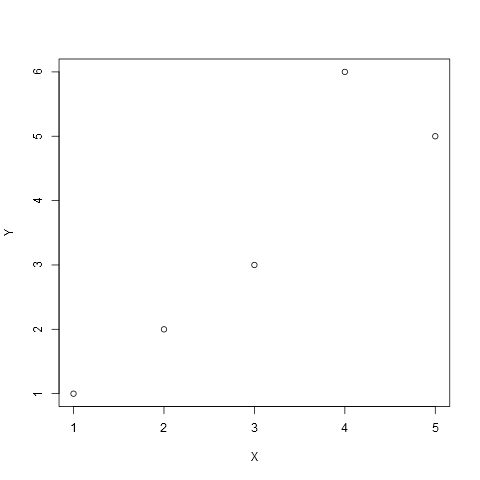

v1 is: [ 10.2]
v2 is: [ 10.2]


In [97]:
v1 = %R plot(X,Y); print(summary(lm(Y~X))); vv=mean(X)*mean(Y)
print('v1 is:', v1)
v2 = %R mean(X)*mean(Y)
print('v2 is:', v2)

## What value is returned from %R?

Some calls have no particularly interesting return value, the magic %R will not return anything in this case. The return value in rpy2 is actually NULL so %R returns None.

Also, if the return value of a call to %R (in line mode) has just been printed to the console, then its value is also not returned.

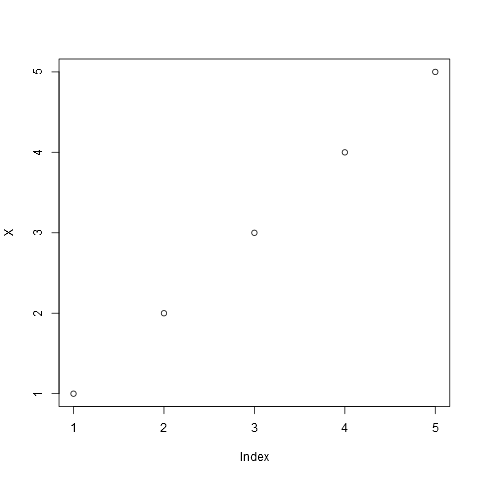

In [98]:
v = %R plot(X)
assert (v is None)

But, if the last value did not print anything to console, the value is returned:


In [99]:
v = %R print(summary(X)); X
print('v:', v)

v: [ 1.  2.  3.  4.  5.]


The return value can be suppressed by a trailing ';' or an -n argument.


In [100]:
%R -n X

In [101]:
%R X; 

## Cell level magic

Often, we will want to do more than a simple linear regression model. There may be several lines of R code that we want to 
use before returning to python. This is the cell-level magic.


For the cell level magic, inputs can be passed via the -i or --inputs argument in the line. These variables are copied 
from the shell namespace to R's namespace using rpy2.robjects.r.assign. It would be nice not to have to copy these into R: rnumpy ( http://bitbucket.org/njs/rnumpy/wiki/API ) has done some work to limit or at least make transparent the number of copies of an array. This seems like a natural thing to try to build on. Arrays can be output from R via the -o or --outputs argument in the line. All other arguments are sent to R's png function, which is the graphics device used to create the plots.

We can redo the above calculations in one ipython cell. We might also want to add some output such as a summary
 from R or perhaps the standard plotting diagnostics of the lm.

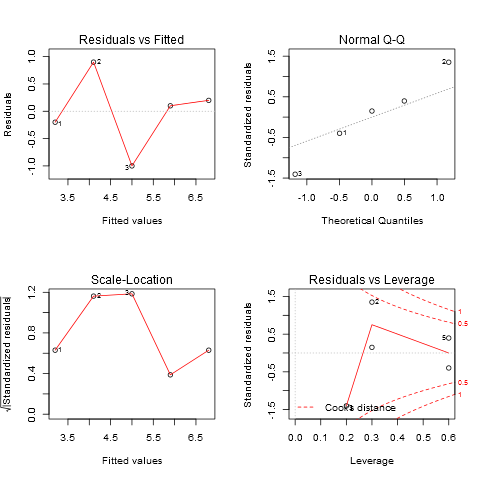

In [102]:
%%R -i X,Y -o XYcoef
XYlm = lm(Y~X)
XYcoef = coef(XYlm)
print(summary(XYlm))
par(mfrow=c(2,2))
plot(XYlm)

## Passing data back and forth

Currently, data is passed through RMagics.pyconverter when going from python to R and RMagics.Rconverter when 
going from R to python. These currently default to numpy.ndarray. Future work will involve writing better converters, most likely involving integration with http://pandas.sourceforge.net.

Passing ndarrays into R seems to require a copy, though once an object is returned to python, this object is NOT copied, and it is possible to change its values.


In [103]:
seq1 = np.arange(10)

In [104]:
%%R -i seq1 -o seq2
seq2 = rep(seq1, 2)
print(seq2)

In [105]:
seq2[::2] = 0
seq2

array([0, 1, 0, 3, 0, 5, 0, 7, 0, 9, 0, 1, 0, 3, 0, 5, 0, 7, 0, 9], dtype=int32)

In [106]:
%%R
print(seq2)

Once the array data has been passed to R, modifring its contents does not modify R's copy of the data.

In [107]:
seq1[0] = 200
%R print(seq1)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int32)

But, if we pass data as both input and output, then the value of "data" in user_ns will be overwritten and the
new array will be a view of the data in R's copy.

In [108]:
print(seq1)
%R -i seq1 -o seq1
print(seq1)
seq1[0] = 200
%R print(seq1)
seq1_view = %R seq1
assert(id(seq1_view.data) == id(seq1.data))

[200   1   2   3   4   5   6   7   8   9]
[200   1   2   3   4   5   6   7   8   9]


## Exception handling

Exceptions are handled by passing back rpy2's exception and the line that triggered it.

In [109]:
try:
    %R -n nosuchvar
except Exception as e:
    print(e.message)
    pass


Error in withVisible({ : object 'nosuchvar' not found


## R Graphics

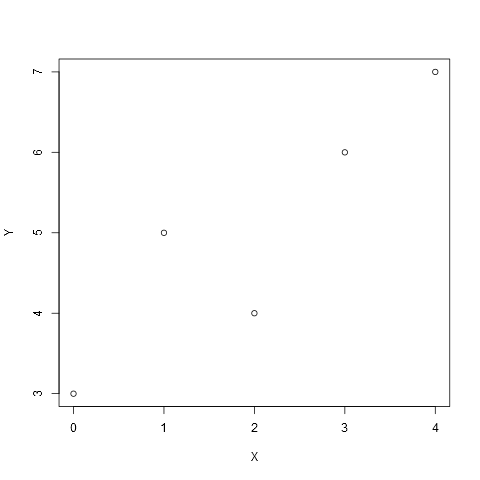

In [110]:
%R plot(X,Y)